In [1]:
import subprocess
from PyQt5.QtWidgets import QFileDialog
import re
import pandas as pd
import numpy as np
import os
import sys
from shutil import copy, copyfile
from pathlib import Path
from pandas.core import groupby

from tikzplotlib import save as tikz_save
import matplotlib.pyplot as plt

workdir = Path.cwd()
results = workdir.joinpath(Path("./results"))
plt.style.use('ggplot')
my_env = os.environ.copy()
my_env["PATH"] = "/home/daniel/.cargo/bin:" + my_env["PATH"]

In [2]:
%gui qt


def gui_file_name(dir=None):
    """Select a file via a dialog and return the file name."""
    if dir is None:
        dir = './'
    file_name = QFileDialog.getOpenFileName(None, "Select data file...",
                                            dir, filter="CSV Files (*.csv)")
    return file_name[0]



In [4]:
file_name = gui_file_name(workdir.__str__())
file_path = Path(file_name)
data = pd.read_csv(file_name, index_col=False)
match = re.search(r'CG_overall\_(20\d{2})\_(\d{2})\_(\d{2})\.csv', file_name)
year = match.group(1)
month = match.group(2)
day = match.group(3)


In [5]:
data['gap'] = (data['global_upper_bound'] - data['global_lower_bound']
               )/(data['global_lower_bound'] + 0.00001)
data['opt'] = data['global_lower_bound'] == data['global_upper_bound']
data['reduction'] = (data['first_size_graph'] -
                     data['size_after_reduced_cost'])/(data['first_size_graph'] + 0.000001)
data['Inst'] = data.NameInstance.apply(
    lambda x:  int(re.search(r'.*\_(\d+)', x).group(1)))



In [6]:
best = data.sort_values(by=['tot_bb']).drop_duplicates(['Inst','n','m'],keep='first')

In [7]:

results_path = results.joinpath("./results_{}_{}_{}".format(year, month, day))

if results_path.exists() == False:
    os.mkdir(results_path)

# copy(file_path, results_path.joinpath(match.group(0)))
tex_file = str()


In [10]:
best.columns

Index(['NameInstance', 'n', 'm', 'tot_real_time', 'tot_cputime', 'tot_bb',
       'tot_lb', 'tot_lb_root', 'tot_heuristic', 'tot_build_dd', 'tot_pricing',
       'tot_reduce_cost_fixing', 'rel_error', 'global_lower_bound',
       'global_upper_bound', 'first_rel_error', 'global_upper_bound_root',
       'global_lowerbound_root', 'nb_generated_col', 'nb_generated_col_root',
       'nb_nodes_explored', 'date', 'nb_iterations_rvnd', 'stabilization',
       'alpha', 'pricing_solver', 'first_size_graph',
       'size_after_reduced_cost', 'strong_branching', 'branching_point',
       'refinement', '()', 'pruning_test', 'suboptimal_duals',
       'scoring_parameter', 'scoring_value', 'mip_nb_vars', 'mip_nb_constr',
       'mip_obj_bound', 'mip_obj_bound_lp', 'mip_rel_gap', 'mip_run_time',
       'mip_status', 'mip_nb_iter_simplex', 'gap', 'opt', 'reduction', 'Inst'],
      dtype='object')

In [7]:
template_dir_path = workdir.joinpath("./template_dir")
for lst in template_dir_path.iterdir():
    if lst.name == "template_table.tex":
        copy(lst, results_path.joinpath(
            "CG_tables_{}_{}_{}.tex".format(year, month, day)))
        tex_file = str(results_path.joinpath(
            "CG_tables_{}_{}_{}.tex".format(year, month, day)))
    else:
        copy(lst, results_path.joinpath(lst.name))
r = subprocess.run(["CG_summary_20191004.csv", "CG_summary_{}_{}_{}.csv ".format(
    year, month, day), tex_file], executable='sd', env=my_env)



In [8]:
summary_grouped = data.groupby(['pricing_solver', 'n', 'm'])
aggregation = {"tot_lb": {np.max, np.mean},
               "tot_lb_root": {np.max, np.mean},
               "gap": {np.max, np.mean},
               "first_size_graph": {np.max, np.mean},
               "size_after_reduced_cost": {np.max, np.mean},
               "opt": np.sum,
               "reduction": {np.max, np.mean},
               "tot_cputime": {np.max, np.mean}}
summary_write = summary_grouped.agg(aggregation).pivot_table(index=['n', 'm'], values=[
    'tot_lb', 'tot_lb_root', 'size_after_reduced_cost', 'gap', 'first_size_graph', 'reduction', 'opt'], columns=['pricing_solver'])
summary_write.columns.set_levels(
    ['AFBC', 'TI', 'ATI'], level=2, inplace=True)
summary_write.columns = ["_".join(x) for x in summary_write.columns.ravel()]
summary_write.to_csv(results_path.joinpath(
    "CG_summary_{}_{}_{}.csv".format(year, month, day)))


<ipython-input-8-11e986952c97>:12: FutureWarning: inplace is deprecated and will be removed in a future version.
  summary_write.columns.set_levels(
<ipython-input-8-11e986952c97>:14: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  summary_write.columns = ["_".join(x) for x in summary_write.columns.ravel()]


In [11]:
all_instances = best.pivot_table(values=['tot_lb', 'gap', 'first_size_graph', 'reduction', 'opt', 'rel_error', 'nb_generated_col',
                                         'global_lower_bound', 'global_upper_bound', 'tot_cputime', 'tot_bb','first_rel_error','nb_generated_col_root','nb_nodes_explored','size_after_reduced_cost','global_lowerbound_root','global_upper_bound_root','tot_lb_root'], index=['n', 'm', 'Inst'], columns=['pricing_solver'])
all_instances.columns.set_levels(
    ['AFBC'], level=1, inplace=True)
all_instances.columns = ["_".join(x) for x in all_instances.columns.ravel()]
all_instances.to_csv(
    results_path.joinpath(
        "TUE_server_results_{}_{}_{}.csv".format(year, month, day)))


<ipython-input-11-28b62c62c90d>:3: FutureWarning: inplace is deprecated and will be removed in a future version.
  all_instances.columns.set_levels(
<ipython-input-11-28b62c62c90d>:5: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  all_instances.columns = ["_".join(x) for x in all_instances.columns.ravel()]


In [10]:
df_oliveira = pd.read_csv(workdir.joinpath("oliveira_overall.csv"))


In [11]:
for it in ['tot_real_time', 'tot_cputime', 'tot_bb', 'tot_lb', 'tot_lb_root', 'tot_heuristic', 'tot_build_dd', 'tot_pricing', 'tot_reduce_cost_fixing']:
    best["adjusted_{}".format(it)] = 0.6*best[it]

df_oliveira_opt = df_oliveira[(df_oliveira['OptFound'] == 1)]
best_opt = best[best['opt']]
df_all_opt = pd.merge(best_opt, df_oliveira_opt, on=['Inst', 'n', 'm'])


In [12]:
agg = {"adjusted_tot_bb": {np.mean, np.max, np.min}, "TimeOliveira": {np.mean, np.max, np.min},  "adjusted_tot_lb_root": {
    np.mean, np.min, np.max}, "opt": np.sum, "OptFound": np.sum}
grouped = df_all_opt.groupby(['n', 'm'])
grouped.agg(agg)



adjusted_tot_bb                        TimeOliveira                      \
                 amax       amin        mean         amax   amin         mean   
n   m                                                                           
40  2      196.809961   1.677212   34.671193        736.6    4.3    55.512500   
    4       33.465331   0.306859    6.516393        166.6    2.9    30.156250   
50  2      246.745881   3.534318   48.227616         58.0    6.3    18.650000   
    4      125.416735   1.296911   21.691796       1771.8    5.6   272.588235   
100 2     3009.559399  14.927492  648.757420        347.6   40.1   169.136364   
    4     2020.761994  22.751194  726.464795       2994.0  156.1  1230.490000   

      adjusted_tot_lb_root                      opt OptFound  
                      amax      amin       mean sum      sum  
n   m                                                         
40  2             2.133679  0.556651   1.317351  16       16  
    4             1.095620  0.145974   0.596982  16       16  
50  2             3.692109  1.278944   2.672372  18       18  
    4             2.485450  0.384517   1.585047  17       17  
100 2            43.438999  9.941957  24.021156  11       11  
    4            22.450630  3.454280  13.919023  10       10

In [13]:
all_df = pd.merge(best, df_oliveira,on=['Inst','n','m'],how='outer')

In [14]:

weight_oliveira = all_df['OptFound'].fillna(0.0)
all_df["opt_TimeOliveira"] = weight_oliveira * all_df["TimeOliveira"]
all_df["opt_tot_bb"] = all_df["opt"]*all_df["adjusted_tot_bb"]
all_df["opt_found_tot_bb"] = weight_oliveira*all_df["opt"]*all_df["adjusted_tot_bb"]
all_df["opt_found"] = weight_oliveira*all_df["opt"]


def mean_opt_func(x):
	s = x.sum()
	return s/(x > 0).sum()

In [21]:

agg = {"opt_tot_bb": {mean_opt_func}, "opt_TimeOliveira": {mean_opt_func}, "opt_found_tot_bb": {mean_opt_func}, "opt_found":{np.sum},"opt": {np.sum}, "OptFound": {np.sum}}
grouped = all_df.groupby(['n', 'm'])
summary_opt = grouped.agg(agg)

In [22]:

# summary_opt.columns.set_levels(
#     ['AFBC', 'TI', 'ATI'], level=1, inplace=True)
summary_opt.columns = ["_".join(x) for x in summary_opt.columns.ravel()]
summary_opt.to_csv(results_path.joinpath(
    "TUEserver_summary_opt_{}_{}_{}.csv".format(year, month, day)))

<ipython-input-22-7a2f6857bc3b>:3: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  summary_opt.columns = ["_".join(x) for x in summary_opt.columns.ravel()]


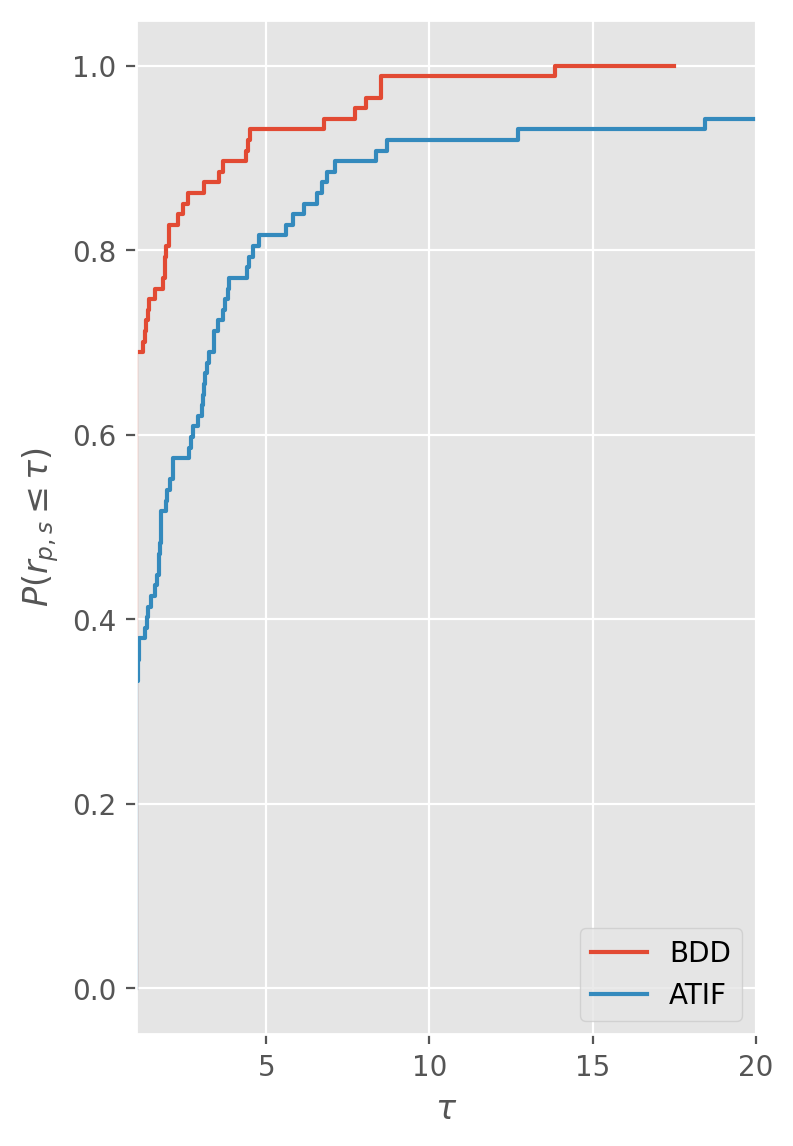

In [16]:
df_all_opt['best_solver'] = df_all_opt[['adjusted_tot_bb', 'TimeOliveira']].min(axis=1)
df_all_opt['ratio_tot_bb_best'] = df_all_opt['adjusted_tot_bb'] / \
    df_all_opt['best_solver']

df_all_opt['ratio_TimeOliveira_best'] = df_all_opt['TimeOliveira'] / \
    df_all_opt['best_solver']

sorted_ratio_tot_bb = df_all_opt[['ratio_tot_bb_best']
                                 ].sort_values(by='ratio_tot_bb_best')
yvals = np.arange(len(sorted_ratio_tot_bb)) / \
    float(len(sorted_ratio_tot_bb) - 1.0)

sorted_ratio_TimeOliveira = df_all_opt[['ratio_TimeOliveira_best']].sort_values(
    by='ratio_TimeOliveira_best')

yvalues = np.arange(len(sorted_ratio_TimeOliveira)) / \
    float(len(sorted_ratio_TimeOliveira) - 1.0)

width, height = plt.figaspect(1.68)
fig, ax = plt.subplots(figsize=(width, height), dpi=200)
ax.step(sorted_ratio_tot_bb, yvals, label='BDD')
ax.step(sorted_ratio_TimeOliveira, yvalues, label='ATIF')
ax.set_xlim([10.0**0, 20])
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$P(r_{p,s} \leq \tau)$")
ax.legend(loc='lower right')
name_file = 'profile_curve_overall_{}_{}_{}.tex'.format(year, month, day)
tikz_save(results_path.joinpath(name_file))
plt.savefig(results_path.joinpath('profile_curve_overall_{}_{}_{}.pdf'.format(
    year, month, day)), dpi=200)


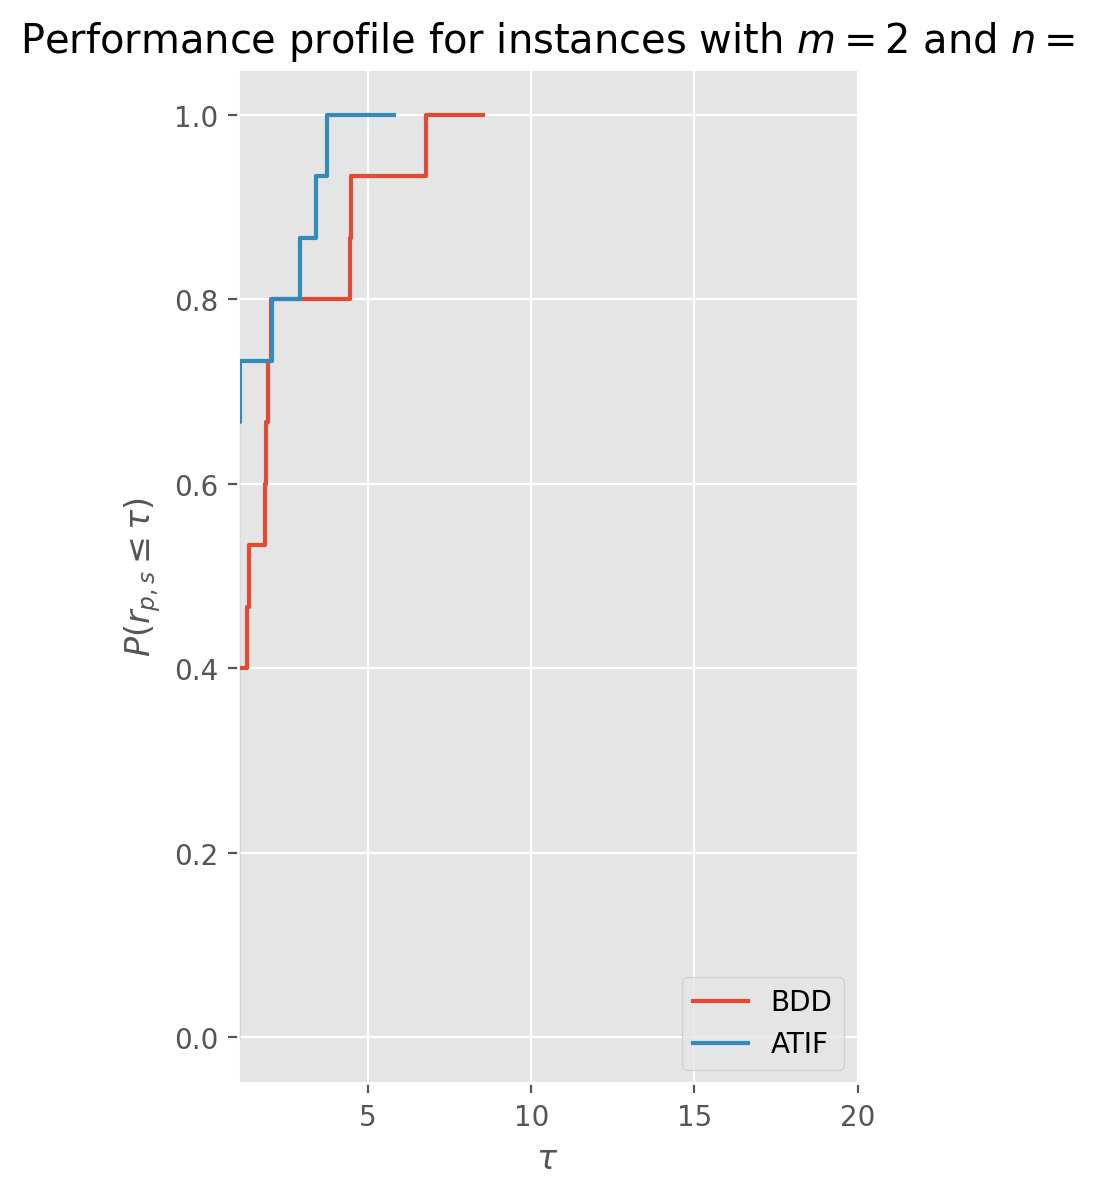

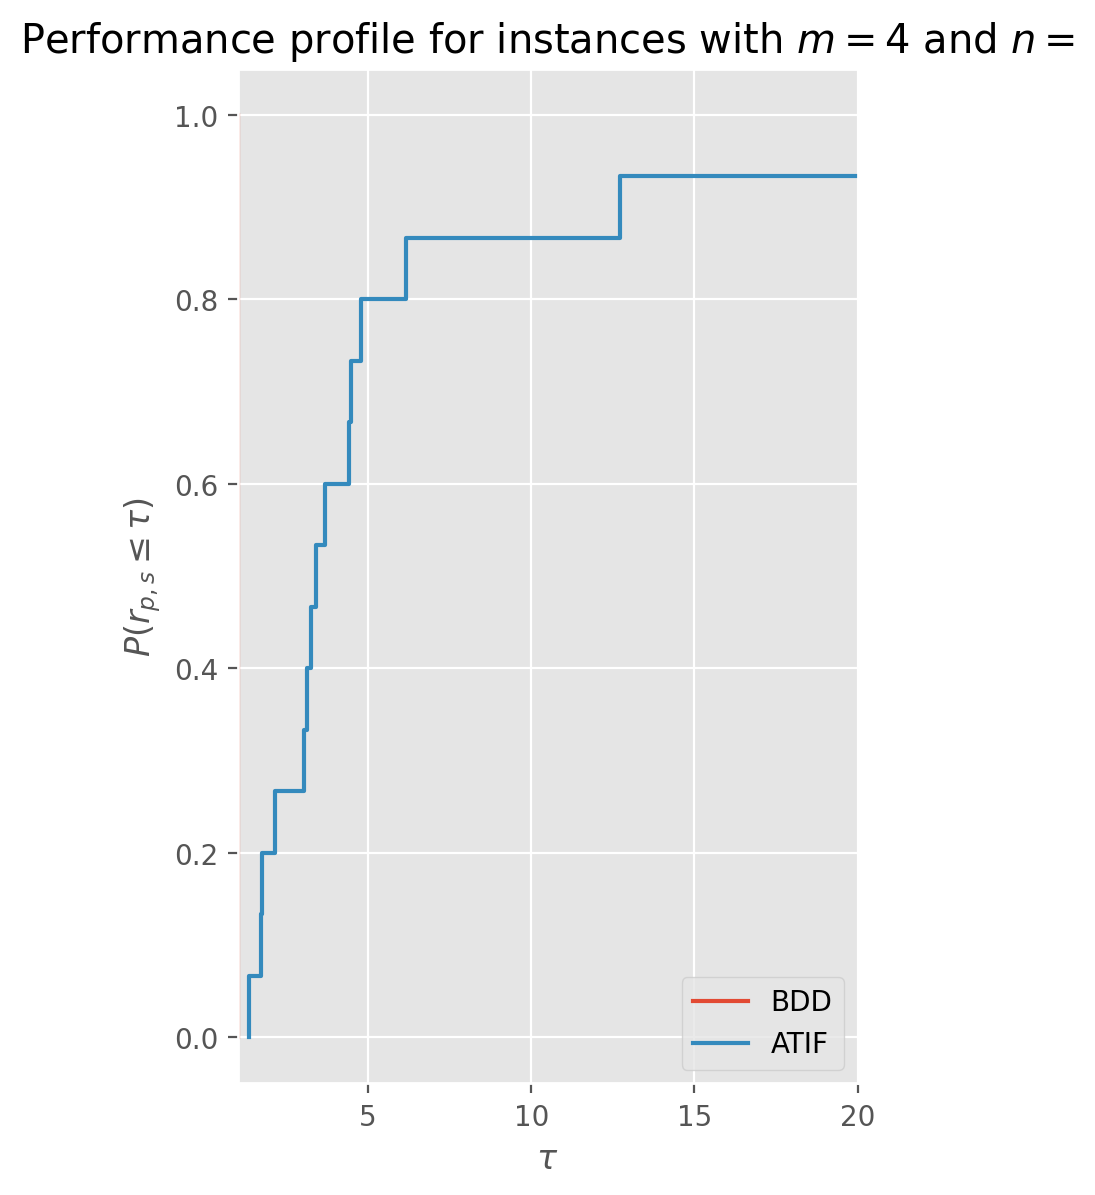

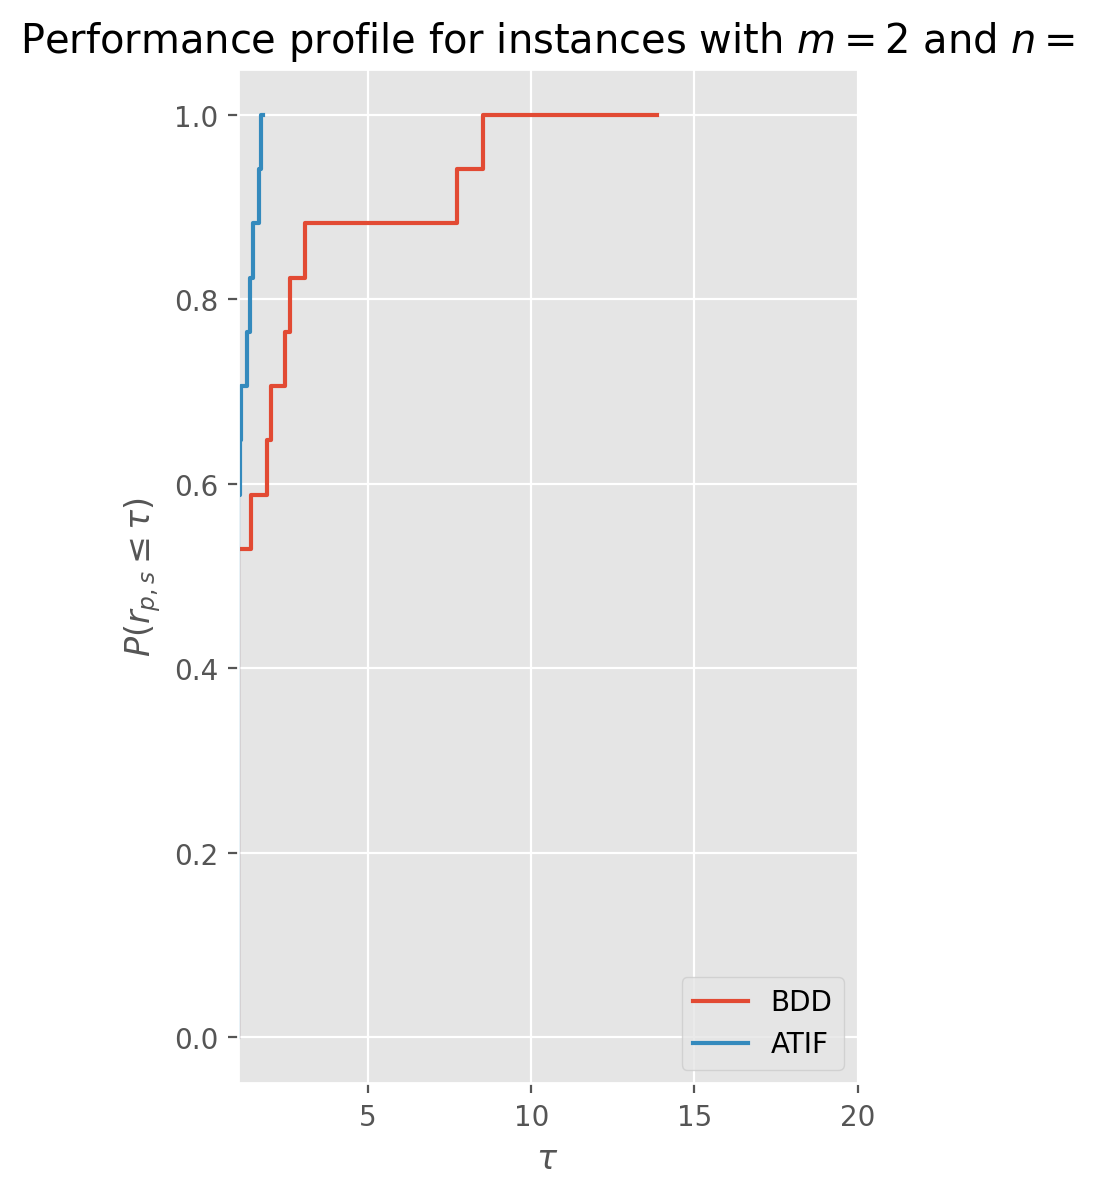

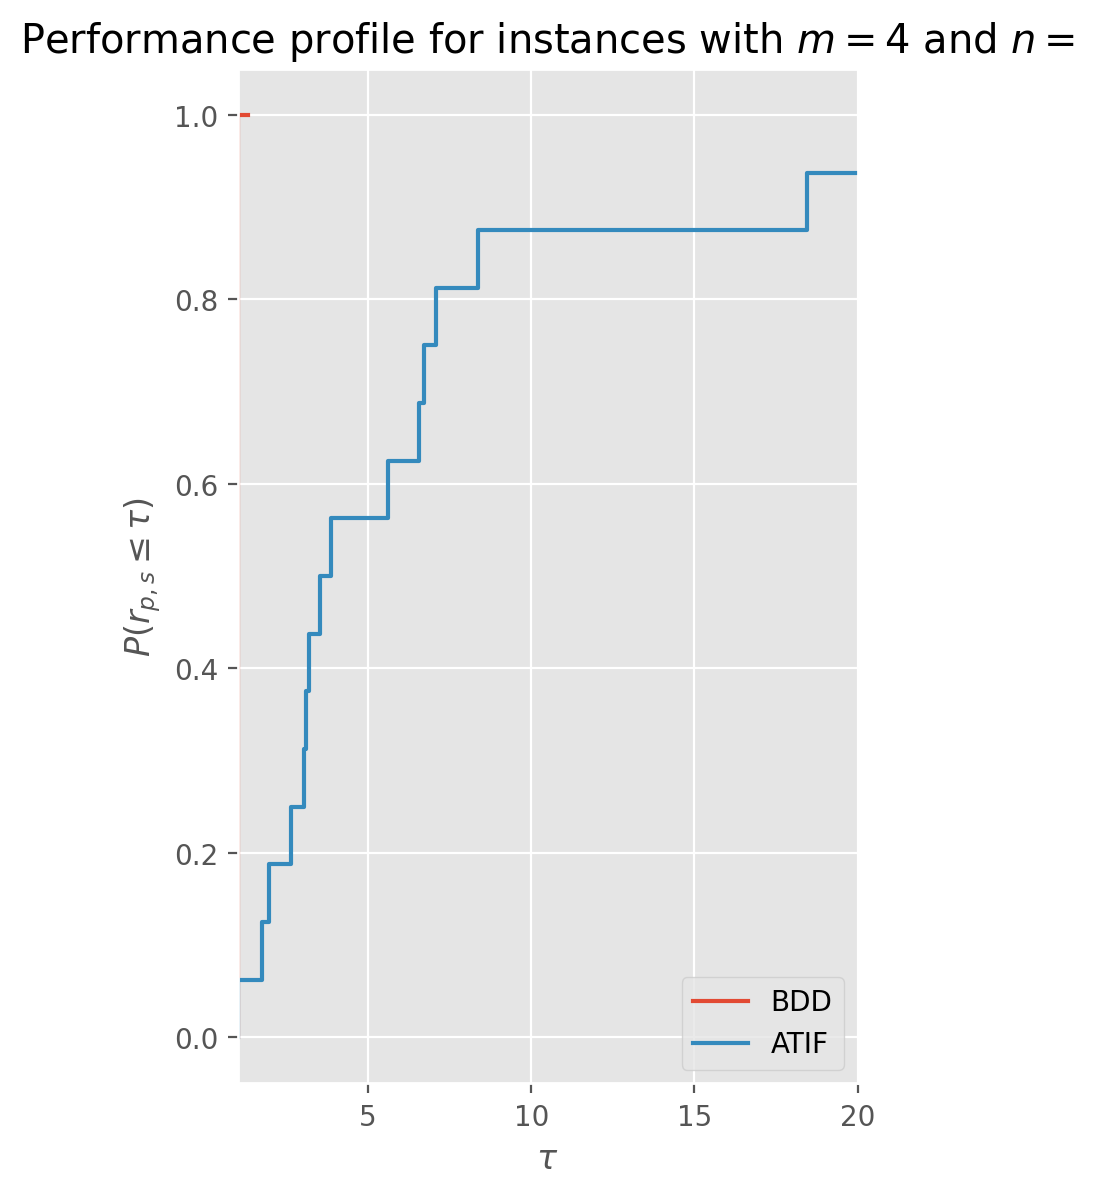

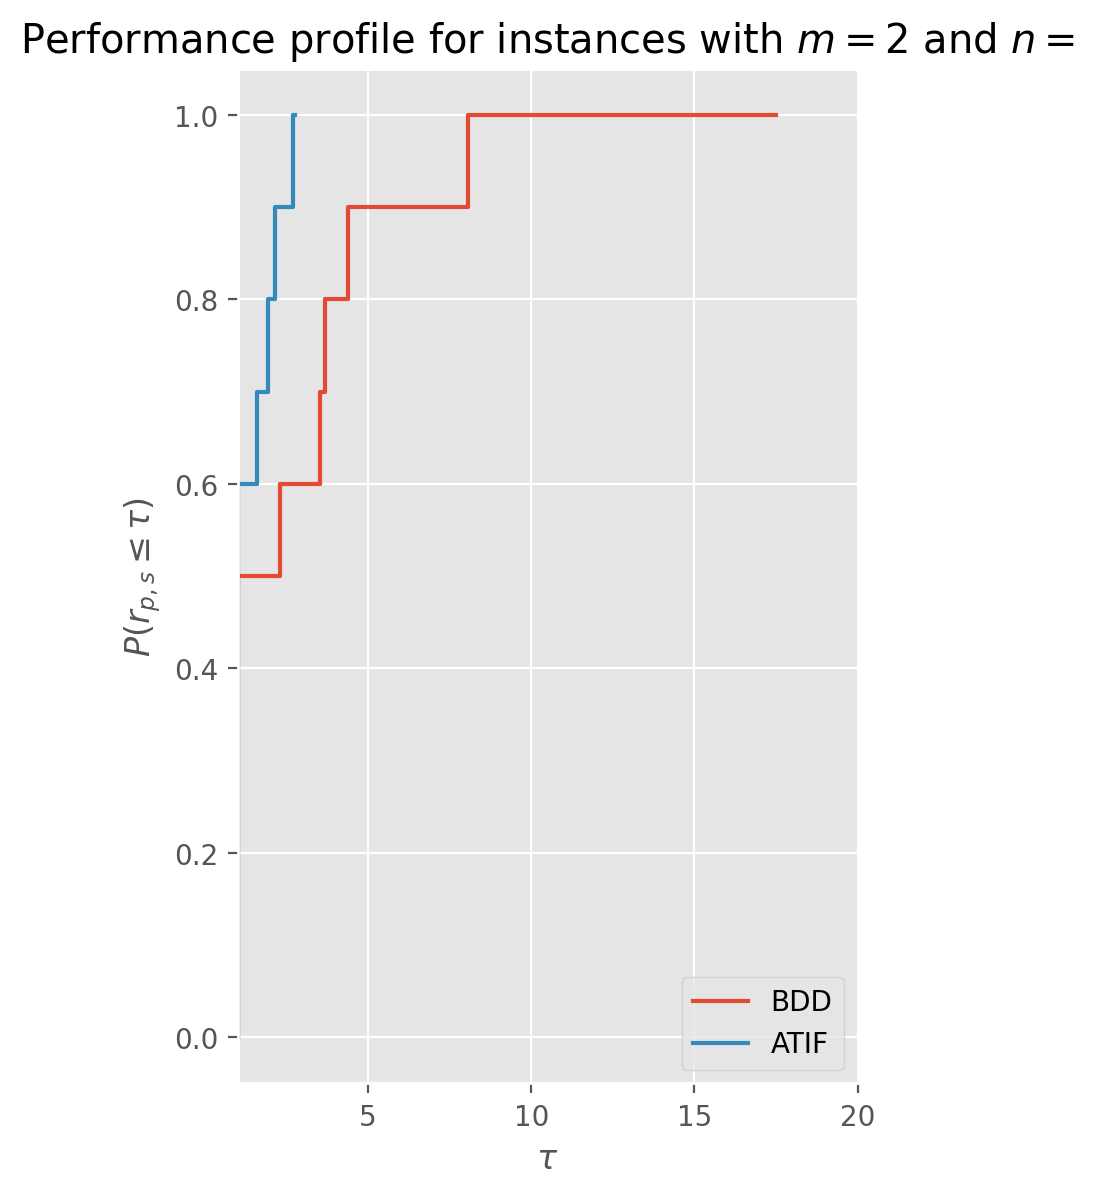

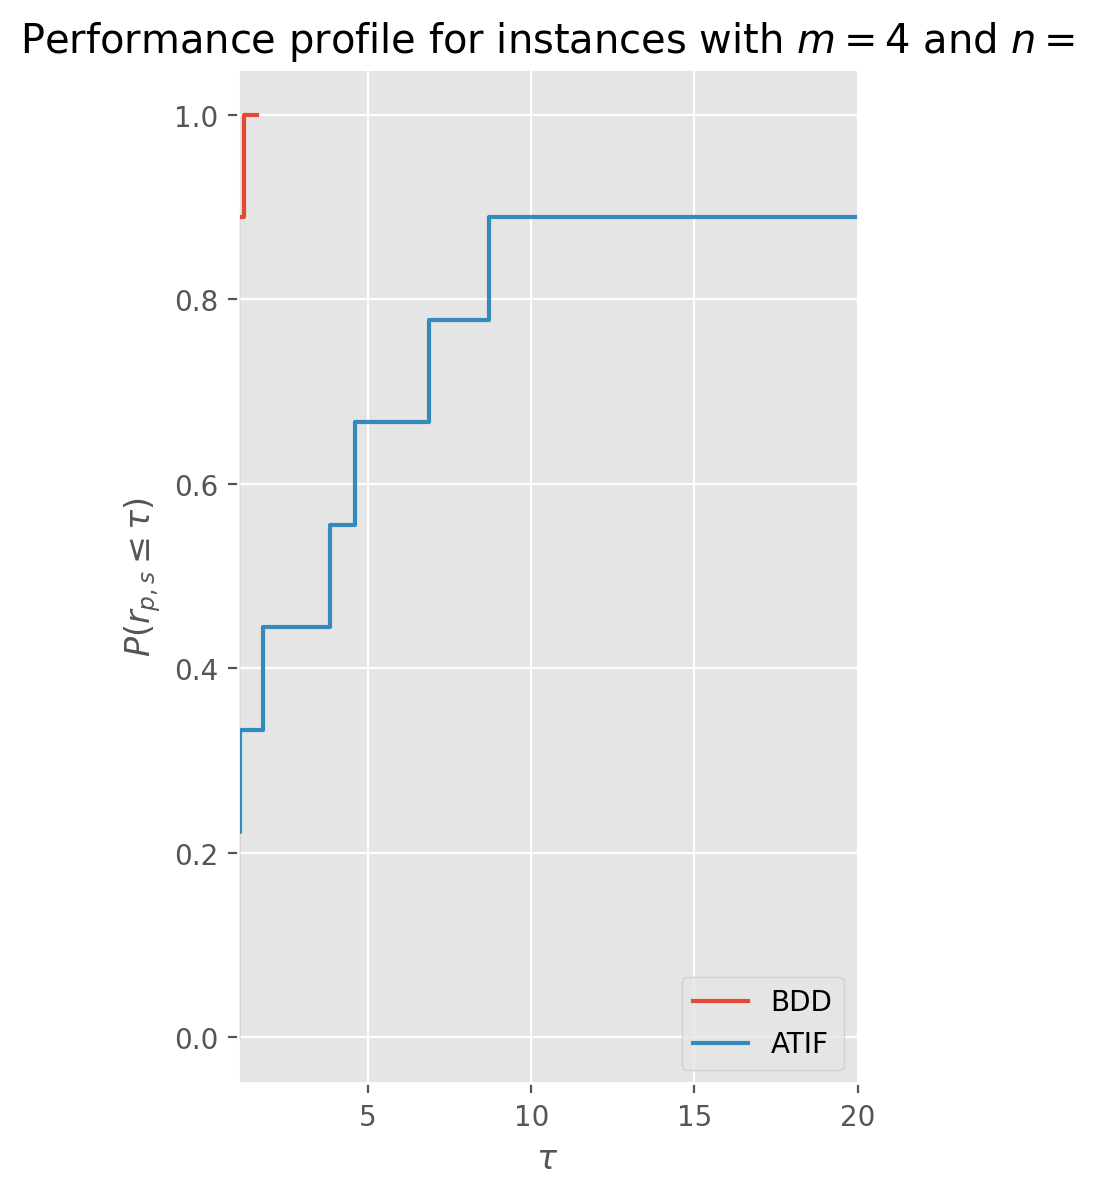

In [17]:
for n in [40, 50, 100]:
    for m in [2, 4]:
        sorted_ratio_tot_bb = df_all_opt.loc[(df_all_opt['n'] == n) & (
            df_all_opt["m"] == m), "ratio_tot_bb_best"].sort_values()
        yvals = np.arange(len(sorted_ratio_tot_bb)) / \
            float(len(sorted_ratio_tot_bb) - 1.0)

        sorted_ratio_TimeOliveira = df_all_opt.loc[(df_all_opt['n'] == n) & (
            df_all_opt["m"] == m), "ratio_TimeOliveira_best"].sort_values()

        yvalues = np.arange(len(sorted_ratio_TimeOliveira)) / \
            float(len(sorted_ratio_TimeOliveira) - 1.0)

        width, height = plt.figaspect(1.68)
        fig, ax = plt.subplots(figsize=(width, height), dpi=200)
        ax.step(sorted_ratio_tot_bb, yvals, label='BDD')
        ax.step(sorted_ratio_TimeOliveira, yvalues, label='ATIF')
        ax.set_xlim([10.0**0, 20])
        ax.set_title(
            "Performance profile for instances with $m = {}$ and $n = $".format(m, n))
        ax.set_xlabel(r"$\tau$")
        ax.set_ylabel(r"$P(r_{p,s} \leq \tau)$")
        ax.legend(loc='lower right')
        name_file = 'profile_curve_{}_{}_{}_{}_{}.tex'.format(
            n, m, year, month, day)
        tikz_save(results_path.joinpath(name_file))
        plt.savefig(results_path.joinpath('profile_curve_{}_{}_{}_{}_{}.pdf'.format(
            n, m, year, month, day)), dpi=200)
